<a href="https://colab.research.google.com/github/mukulre/Data-Science-Projects/blob/main/TinyDenseNet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Classes: ['NORMAL', 'PNEUMONIA']
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 125MB/s]



Epoch 1/15
------------------------------
Train Loss: 0.1086 Acc: 0.9630
Val Acc: 0.6875

Epoch 2/15
------------------------------
Train Loss: 0.0583 Acc: 0.9801
Val Acc: 0.8750

Epoch 3/15
------------------------------
Train Loss: 0.0385 Acc: 0.9870
Val Acc: 0.8125

Epoch 4/15
------------------------------
Train Loss: 0.0341 Acc: 0.9872
Val Acc: 1.0000

Epoch 5/15
------------------------------
Train Loss: 0.0269 Acc: 0.9908
Val Acc: 0.9375

Epoch 6/15
------------------------------
Train Loss: 0.0242 Acc: 0.9918
Val Acc: 0.8750

Epoch 7/15
------------------------------
Train Loss: 0.0167 Acc: 0.9952
Val Acc: 1.0000

Epoch 8/15
------------------------------
Train Loss: 0.0164 Acc: 0.9939
Val Acc: 0.9375

Epoch 9/15
------------------------------
Train Loss: 0.0179 Acc: 0.9941
Val Acc: 0.8750

Epoch 10/15
------------------------------
Train Loss: 0.0104 Acc: 0.9979
Val Acc: 0.9375

Epoch 11/15
------------------------------
Train Loss: 0.0121 Acc: 0.9967
Val Acc: 1.0000

Epoch 1

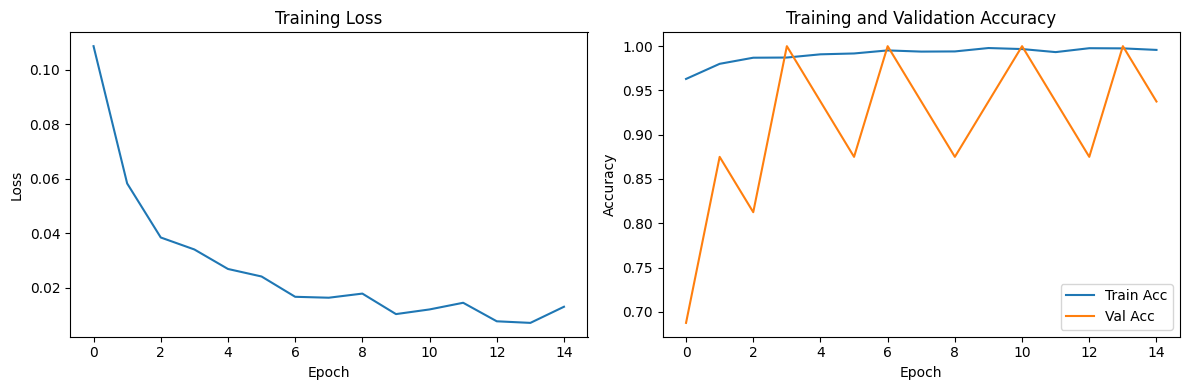


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.75      0.85       234
   PNEUMONIA       0.87      0.99      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



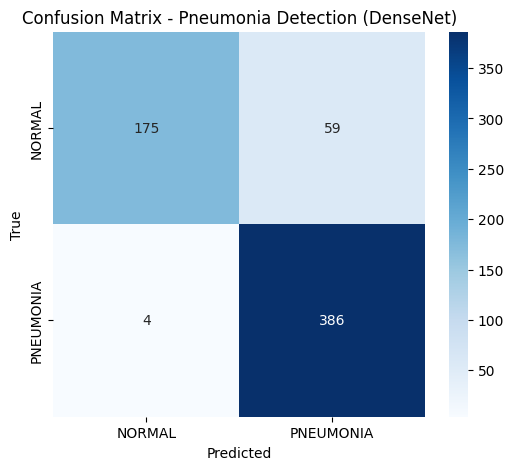


Additional Metrics:
Accuracy: 0.8990
Precision: 0.8674
Recall: 0.9897
F1-Score: 0.9246

Model saved as 'densenet_tiny_pneumonia.pth'


In [ ]:
# -----------------------------
# 1. Imports
# -----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# -----------------------------
# 2. Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 3. Data Preprocessing
# -----------------------------
# Define transforms for train/val/test
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Your dataset should be structured as:
# dataset/
#   train/
#      NORMAL/
#      PNEUMONIA/
#   val/
#      NORMAL/
#      PNEUMONIA/
#   test/
#      NORMAL/
#      PNEUMONIA/

train_dir = "/content/drive/MyDrive/chest_xray/chest_xray/train"
val_dir   = "/content/drive/MyDrive/chest_xray/chest_xray/val"
test_dir  = "/content/drive/MyDrive/chest_xray/chest_xray/test"

train_data = datasets.ImageFolder(train_dir, transform=transform_train)
val_data   = datasets.ImageFolder(val_dir,   transform=transform_test)
test_data  = datasets.ImageFolder(test_dir,  transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

classes = train_data.classes
print("Classes:", classes)

# -----------------------------
# 4. Define Tiny DenseNet Model
# -----------------------------
# Using DenseNet121 as the base (smaller than DenseNet169/201)
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Replace final layer (1000 -> 2 for Normal/Pneumonia)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)

model = model.to(device)

# -----------------------------
# 5. Loss & Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -----------------------------
# 6. Training Loop
# -----------------------------
def train_model(model, epochs=15):
    best_acc = 0.0
    train_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-"*30)

        # Training phase
        model.train()
        running_loss, running_corrects = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_data)
        epoch_acc  = running_corrects.double() / len(train_data)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_data)
        val_accs.append(val_acc.item())
        print(f"Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_densenet_tiny.pth")

    print("\nTraining complete. Best Val Acc:", best_acc)

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accs, val_accs

# Train the model
train_losses, train_accs, val_accs = train_model(model, epochs=15)

# -----------------------------
# 7. Evaluation on Test Set
# -----------------------------
model.load_state_dict(torch.load("best_densenet_tiny.pth"))
model.eval()

all_preds, all_labels = [], []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, 1)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Pneumonia Detection (DenseNet)")
plt.show()

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Save the final model
torch.save(model.state_dict(), "densenet_tiny_pneumonia.pth")
print("\nModel saved as 'densenet_tiny_pneumonia.pth'")